In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import xarray
from abtem.bloch.bloch import StructureFactors
import abtem

xarray.set_options(display_expand_data=False)

abtem.config.set({"device": "gpu"})

(appendix:convergence)=
# Convergence

In this tutorial, we go through how to ensure a multislice simulation with respect to three major convergence parameters: real space sampling, slice thickness and the size of the ensemble, when calculating ensemble means. 

We start by setting the precission to 64-bit floating point, the default is 32-bit, as calculations with extremely small samplings and slice thicknesses can lead to overflow.

In [2]:
abtem.config.set({"precision": "float64"})

## Slice thickness

We now turn convergence with respect to slice thickness, our test system is a simulation diffraction patterns with an acceleration voltage of $200 \ \mathrm{keV}$ and a real space sampling of $0.02 \ \mathrm{Å}$.

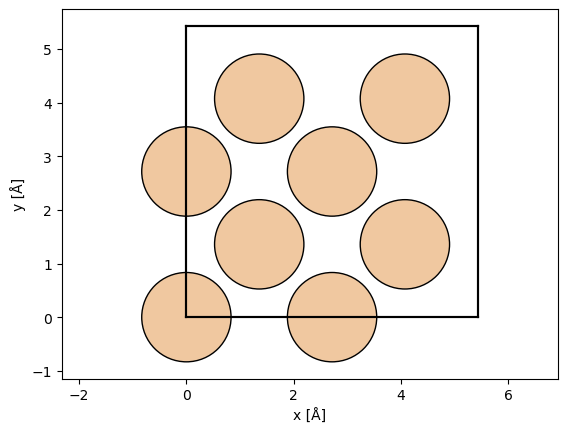

In [11]:
atoms = ase.build.bulk("Si", cubic=True)
abtem.show_atoms(atoms)

wave = abtem.PlaneWave(energy=100e3, sampling=0.02)

We use a geometric sequence halving the slice thickness at each step, starting from the thickness of the entire unit cell, $a/1, a/2, a/4, ..., a/256$.

In [12]:
thickness_fractions = np.array([2**n for n in np.arange(0, 9)])

thicknesses = atoms.cell[2, 2] / thickness_fractions

thicknesses

array([5.43      , 2.715     , 1.3575    , 0.67875   , 0.339375  ,
       0.1696875 , 0.08484375, 0.04242187, 0.02121094])

We test both finite and infinite potential integrals, below the calculations are set up.

In [13]:
structure_factor = StructureFactors(atoms, k_max=23.4, parametrization="lobato")

# Initialize a dictionary to store exit wave data for different projections.
exit_waves_list = {"finite": [], "finite (rs)": [], "infinite": []}

# Loop through specified slice thicknesses and projections.
for thickness in tqdm(thicknesses):
    for projection in exit_waves_list:
        
        # Create a potential for the given projection and thickness.
        if projection == "finite (rs)":
            potential_unit = structure_factor.get_projected_potential(
            slice_thickness=thickness, sampling=wave.sampling
        )
        else:
            potential_unit = abtem.Potential(
                atoms, projection=projection, slice_thickness=thickness, sampling=wave.sampling
            )

        # Define a crystal potential with the potential unit repeated in the z-direction.
        potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 60))

        # Calculate the exit wave using the multislice method.
        exit_wave = wave.multislice(potential).compute()

        # Append the exit wave to the corresponding list in the dictionary.
        exit_waves_list[projection].append(exit_wave)

  0%|          | 0/9 [00:00<?, ?it/s]

[########################################] | 100% Completed | 1.77 ss
[########################################] | 100% Completed | 207.92 ms
[########################################] | 100% Completed | 818.16 ms
[########################################] | 100% Completed | 304.55 ms
[########################################] | 100% Completed | 810.72 ms
[########################################] | 100% Completed | 204.93 ms
[########################################] | 100% Completed | 509.21 ms
[########################################] | 100% Completed | 719.00 ms
[########################################] | 100% Completed | 408.75 ms
[########################################] | 100% Completed | 711.49 ms
[########################################] | 100% Completed | 1.02 ss
[########################################] | 100% Completed | 613.17 ms
[########################################] | 100% Completed | 1.42 ss
[########################################] | 100% Completed | 1.54 ss


We stack all the results to allow for parallelization and to make further analysis easier.

In [15]:
# Define an OrdinalAxis object to represent metadata for the axis.
axes_metadata = abtem.core.axes.OrdinalAxis(
    label="slice thickness", 
    values=[f"a/{f}" for f in thickness_fractions]
)

# Stack the finite exit waves along a new axis using the defined axes metadata.
exit_waves_finite = abtem.stack(exit_waves_list["finite"], axis_metadata=axes_metadata)

exit_waves_finite_rs = abtem.stack(exit_waves_list["finite (rs)"], axis_metadata=axes_metadata)

# Stack the infinite exit waves in the same manner.
exit_waves_infinite = abtem.stack(exit_waves_list["infinite"], axis_metadata=axes_metadata)

# Define new axes metadata, now labeling the axis as "projection" with two values: "finite" and "infinite".
axes_metadata = abtem.core.axes.OrdinalAxis(
    label="projection",  # Label for the new axis
    values=["finite", "finite_rs", "infinite"]  # The two types of projections
)

# Stack the finite and infinite exit waves along a new 'projection' axis.
exit_waves = abtem.stack(
    [exit_waves_finite, exit_waves_finite_rs, exit_waves_infinite],  # List of the two exit wave stacks to combine
    axis_metadata=axes_metadata  # The new axis metadata
)

# Swap the first and second axes of the exit_waves array for plotting
exit_waves = abtem.array.swapaxes(exit_waves, 0, 1)

exit_waves.axes_metadata

type           label            coordinates
-------------  ---------------  ------------------
OrdinalAxis    slice thickness  -
OrdinalAxis    projection       -
RealSpaceAxis  x [Å]            0.00 0.02 ... 5.41
RealSpaceAxis  y [Å]            0.00 0.02 ... 5.41

Compute all the calculations.

In [178]:
exit_waves.compute()

[########################################] | 100% Completed | 192.02 s


We show the exit waves up to a slice thickness of $a/16$, as it becomes difficult to tell differences by eye after this point.

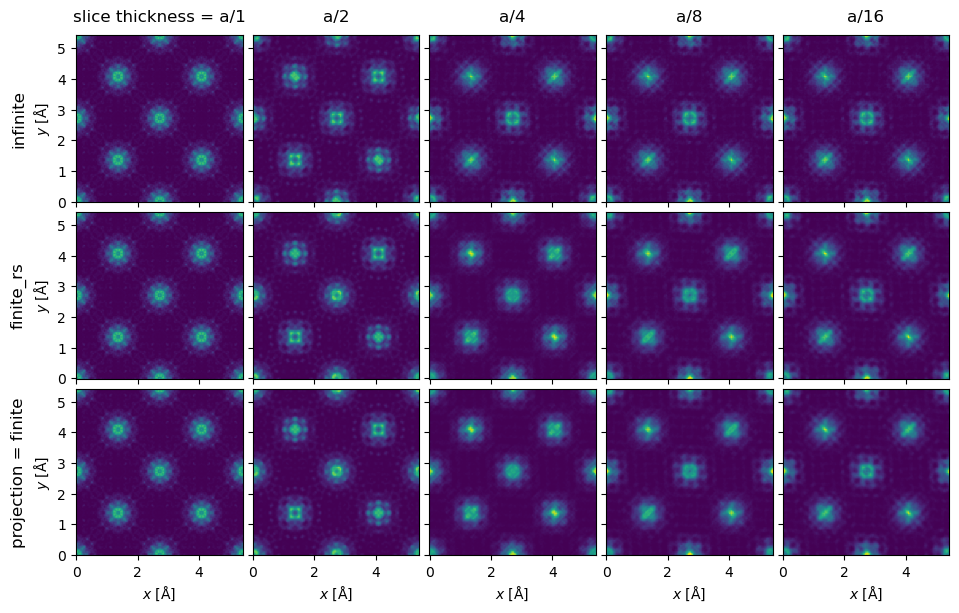

In [16]:
exit_waves[:5].show(explode=True, figsize=(12, 6), common_color_scale=True);

To make the comparison quantitative, we obtain the diffraction spots. We convert the *ab*TEM object to an Xarray `DataArray` to use its more powerful generic data manipulation tools, the *ab*TEM `AxisMetadata` is converted to coordinates.

In [29]:
spots = (
    exit_waves.diffraction_patterns()
    .crop(120)
    .to_cpu()
    .index_diffraction_spots(atoms.cell, centering="F")
)

spots = spots ** .5

data = spots.to_data_array()

data

<xarray.DataArray (slice thickness: 9, projection: 3, hkl: 525)> Size: 113kB
0.002113 7.826e-09 0.001812 0.001057 ... 0.0002654 0.0001902 0.02092 0.0002004
Coordinates:
  * slice thickness  (slice thickness) <U5 180B 'a/1' 'a/2' ... 'a/128' 'a/256'
  * projection       (projection) <U9 108B 'finite' 'finite_rs' 'infinite'
  * hkl              (hkl) <U9 19kB '-18 -18 2' '-18 -16 2' ... '18 18 2'

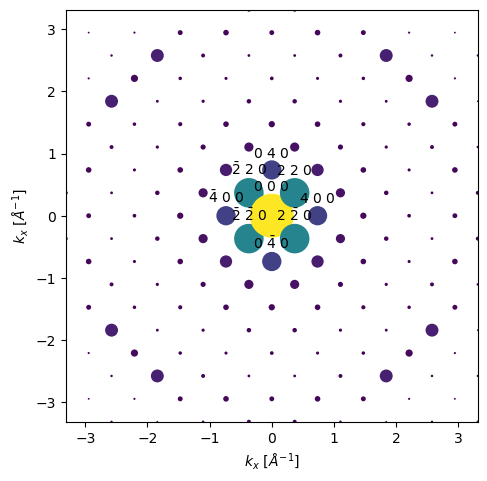

In [30]:
spots.show()

To calculate an error we need to choose a reference calculation, here we use the calculation with the finest finite projection integrals and 

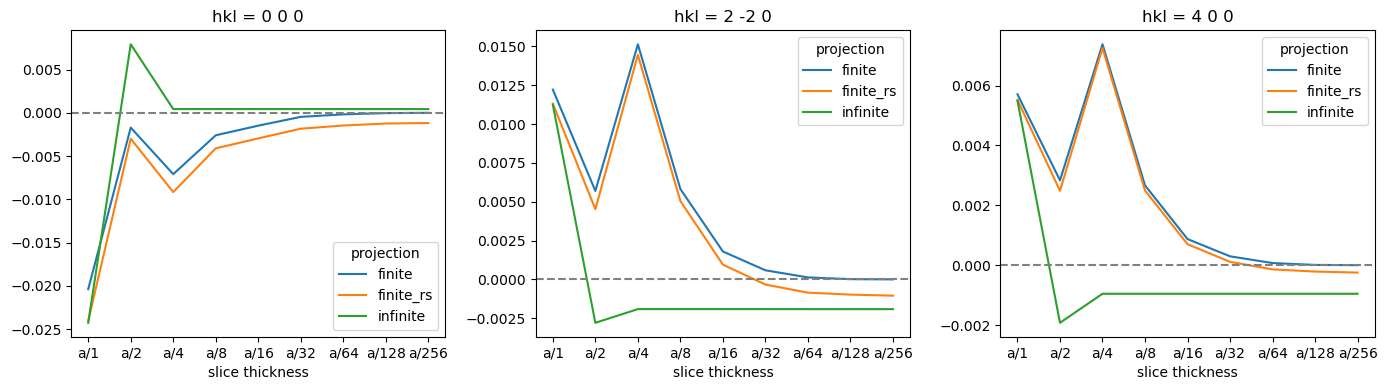

In [31]:
# Select the reference data point
reference = data.sel({"projection": "finite", "slice thickness": "a/256"})

# Calculate the difference between each data point in 'data' and the selected reference.
difference = data - reference 

# Define a list of Miller indices to plot
miller_indices = [
    "0 0 0", 
    "2 -2 0", 
    "4 0 0", 
]

# Create a 1-row, 3-column subplot structure and set the figure size.
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Loop through each subplot axis and corresponding Miller index.
for ax, miller_index in zip(axes, miller_indices):
    # Plot the line graph of the difference data selected by Miller index,
    # with different lines for each projection.
    difference.sel(hkl=miller_index).plot.line(hue="projection", ax=ax)
    
    # Add a horizontal line at y=0 for reference
    ax.axhline(0, color="gray", linestyle="--")

plt.tight_layout()

As there are four atomic planes in the unit cell, any smaller slice thickness beyond $a/4$ does not improve the accuracy, when using the infinite projection. Actually, a any slice thickness that does not have $4$ as a factor may be slightly worse, since such a slice thickness requires shifting the atoms along $z$.

Here, we use the R-factor

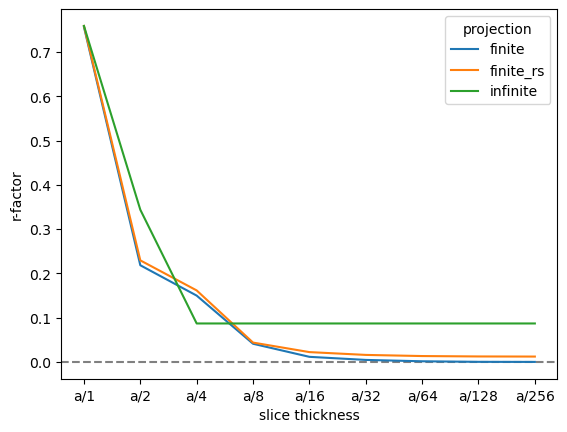

In [33]:
r_factor = np.abs(data - reference).sum("hkl") / np.abs(data).sum("hkl")

fig, ax = plt.subplots()
ax.axhline(0, color="gray", linestyle="--")
r_factor.plot.line(hue="projection", ax=ax)

ax.set_ylabel("r-factor");